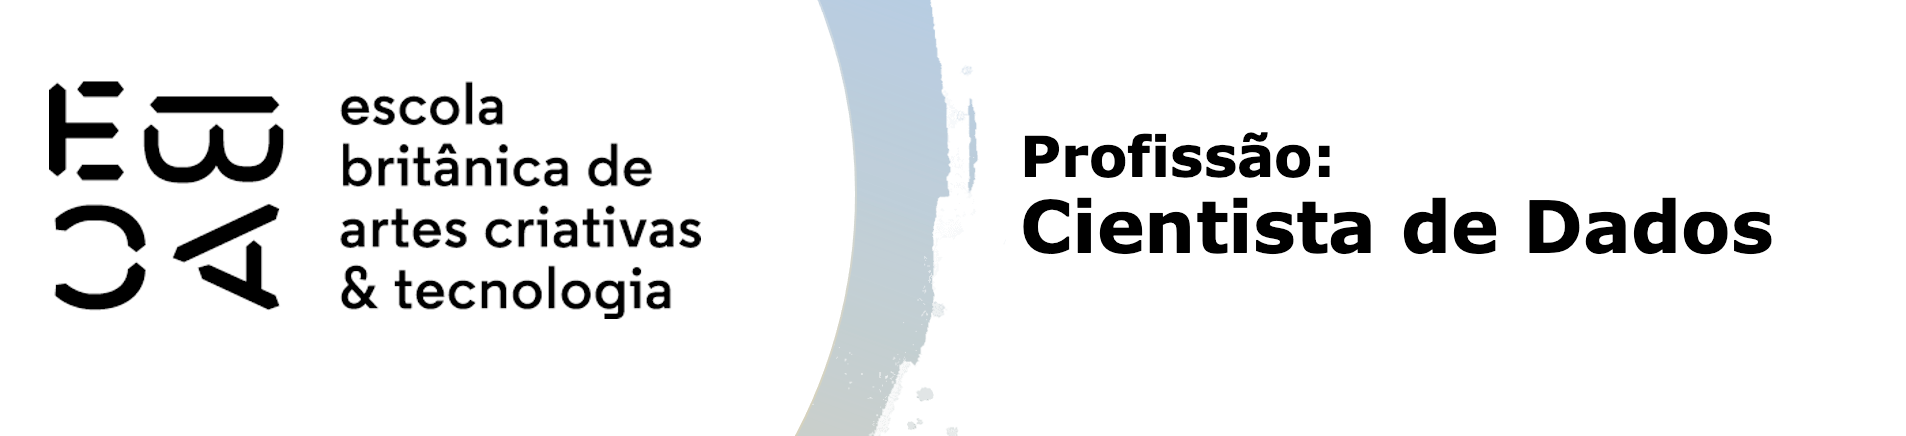

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import t
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve

from pycaret.classification import *

import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

In [2]:
# Definindo as funções utilizadas no código
# Função para calcular o Índice de Informação (IV) de uma variável
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# Função para análise bivariada de variáveis discretas
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)
    
    ax[1] = biv.cont.plot.bar()
    return biv

# Função para análise bivariada de variáveis contínuas
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [3]:
# Lendo o dataset
df = pd.read_feather('credit_scoring.ftr')
df.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Unindo os nomes das colunas do DataFrame com um sinal de '+' e convertendo em uma string.
' + '.join(list(df.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [5]:
# Obtendo a contagem dos valores únicos na coluna 'data_ref'.
df.data_ref.value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [6]:
# Separando a base de dados em treinamento e teste.
# Definindo a coluna 'data_ref' como o índice do DataFrame.
df.set_index('data_ref', inplace=True)

# Selecionando os dados de treinamento.
df_train = df['2015-01-01':'2015-12-01']

# Selecionando os dados de teste.
df_test = df['2016-01-01':]

# Resetando o índice dos DataFrames de treinamento e teste.
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

# Criando uma nova coluna 'Mes'.
df_train['Mes'] = df_train['data_ref'].dt.month

# Ignorando mensagens de aviso.
warnings.filterwarnings('ignore')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

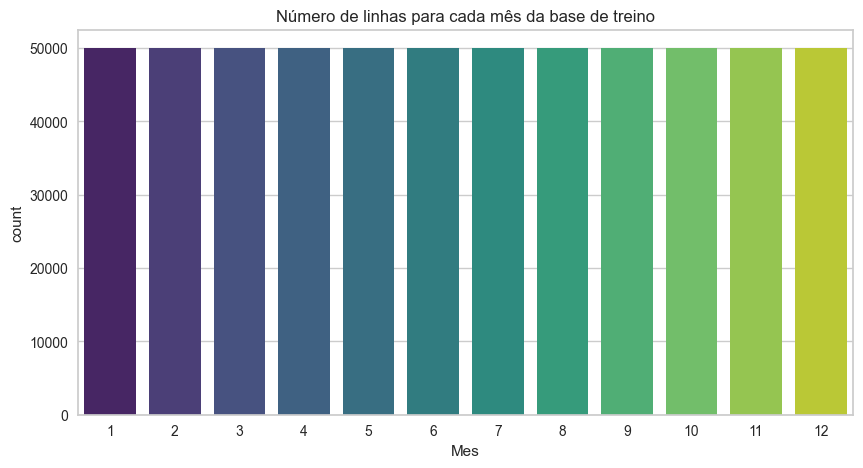

In [7]:
# Criando uma figura e eixo para o gráfico com o tamanho especificado.
fig, ax = plt.subplots(figsize=(10, 5))

# Usando Seaborn para criar um gráfico de contagem (countplot) com base nos dados de treinamento (df_train).
# A variável no eixo x será 'Mes' e a paleta de cores será 'mako'.
sns.countplot(data=df_train, x='Mes', palette='viridis', ax=ax)

# Definindo o título do gráfico.
ax.set_title('Número de linhas para cada mês da base de treino');

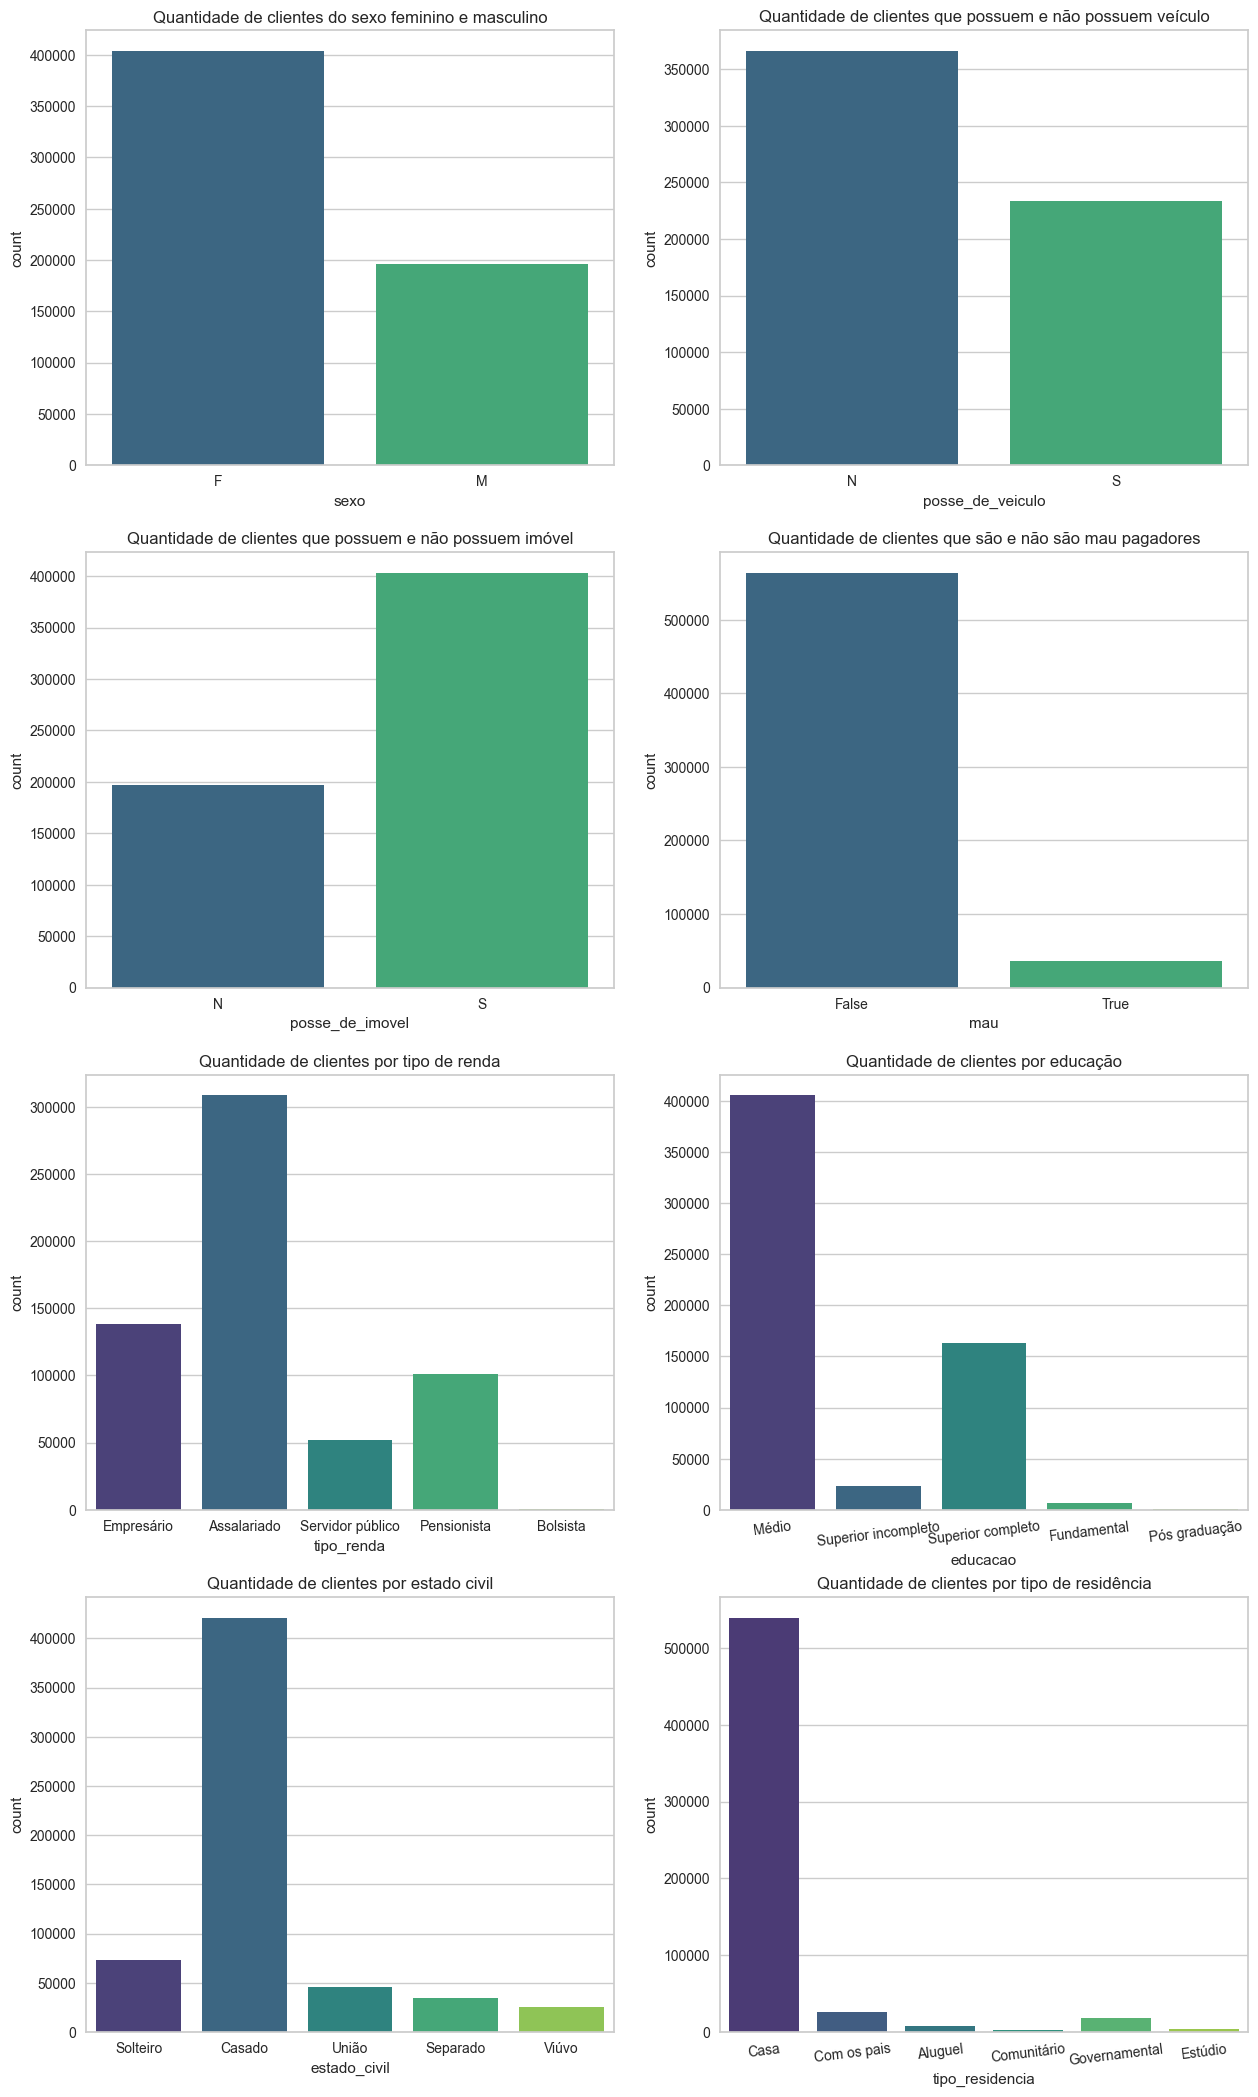

In [8]:
# Criando uma grade de subplots.
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.countplot(data=df_train, x='sexo', palette='viridis', ax=ax[0,0])
ax[0,0].set_title('Quantidade de clientes do sexo feminino e masculino')

sns.countplot(data=df_train, x='posse_de_veiculo', palette='viridis', ax=ax[0,1])
ax[0,1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df_train, x='posse_de_imovel', palette='viridis', ax=ax[1,0])
ax[1,0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df_train, x='mau', palette='viridis', ax=ax[1,1])
ax[1,1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', palette='viridis', ax=ax[2,0])
ax[2,0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', palette='viridis', ax=ax[2,1])
ax[2,1].set_title('Quantidade de clientes por educação')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df_train, x='estado_civil', palette='viridis', ax=ax[3,0])
ax[3,0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', palette='viridis', ax=ax[3,1])
ax[3,1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

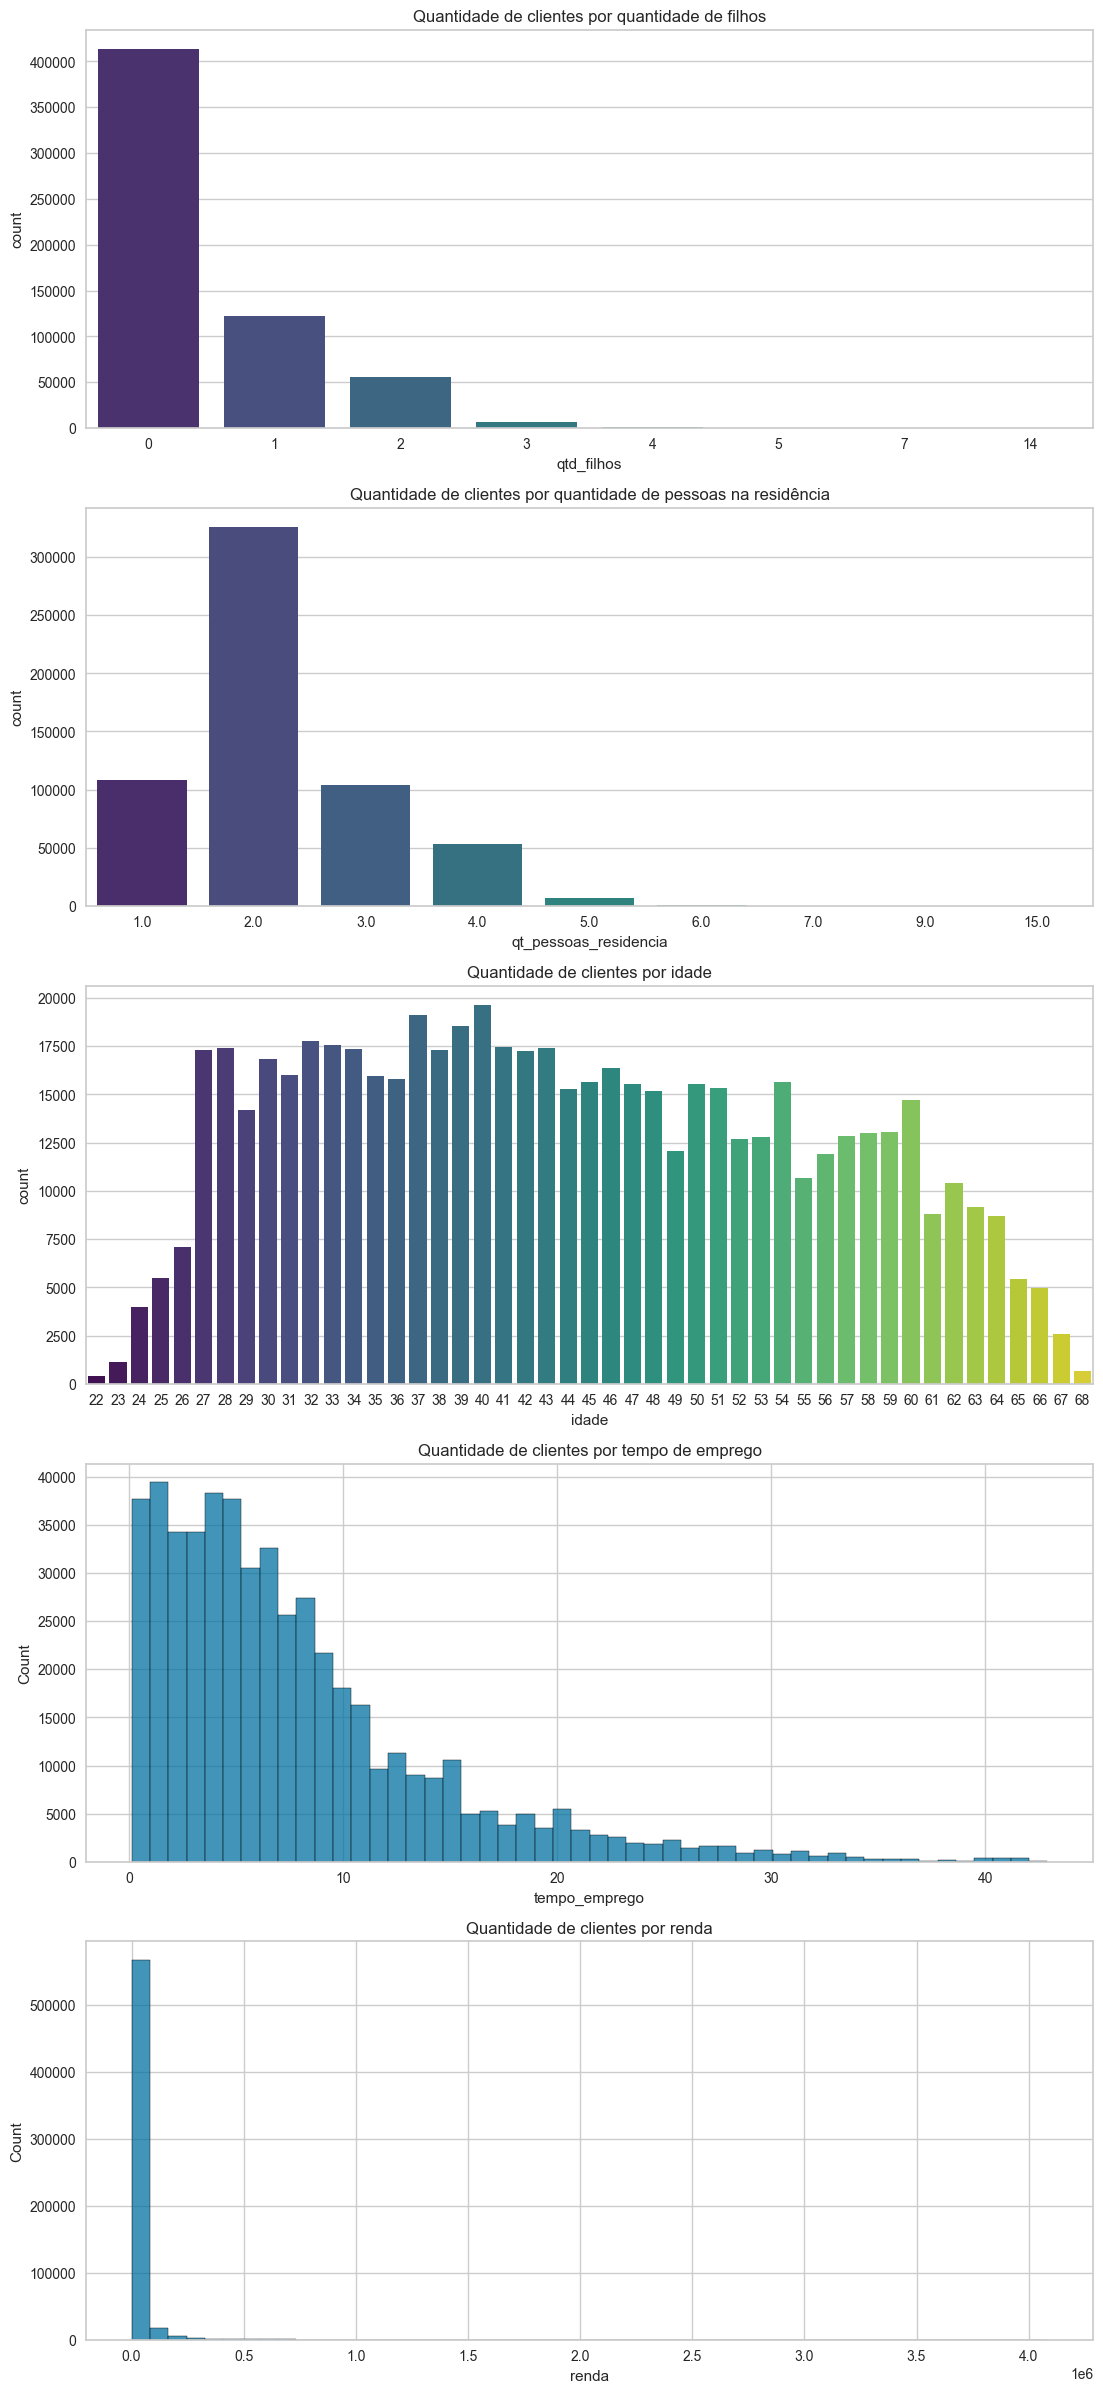

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13,30))

sns.countplot(data=df_train, x='qtd_filhos', palette='viridis', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df_train, x='qt_pessoas_residencia', palette='viridis', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df_train, x='idade', palette='viridis', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df_train, x='tempo_emprego', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df_train, x='renda', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda');

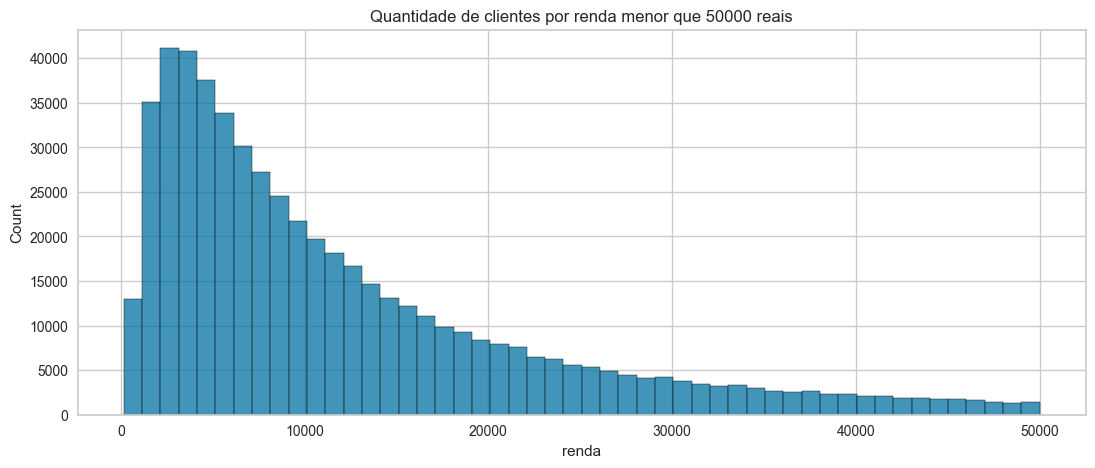

In [10]:
# Plotando um histograma para a coluna 'renda' com renda menor que 50000
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df_train[df_train.renda<50000], x='renda', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda menor que 50000 reais');

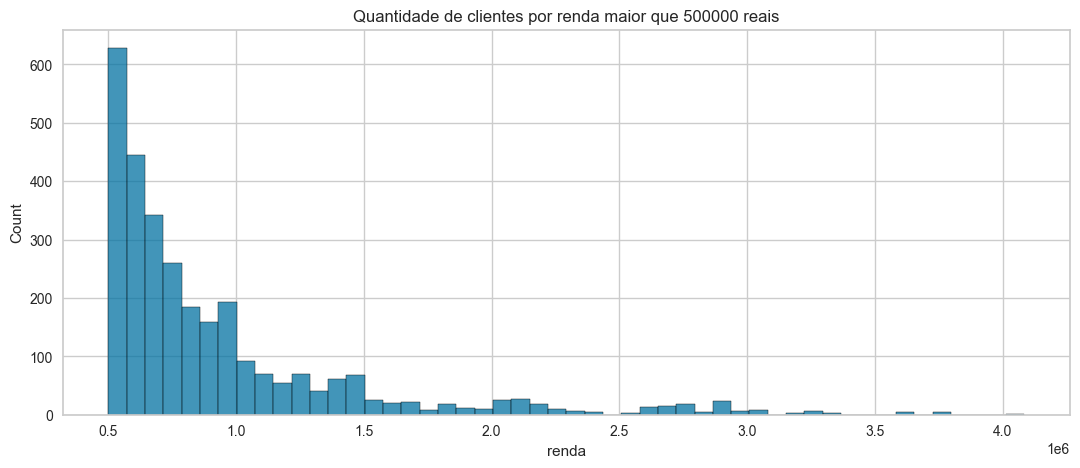

In [11]:
# Plotando um histograma para a coluna 'renda' com renda maior que 50000
fig, ax = plt.subplots(figsize=(13, 5))

sns.histplot(data=df_train[df_train.renda > 500000], x='renda', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda maior que 500000 reais');

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

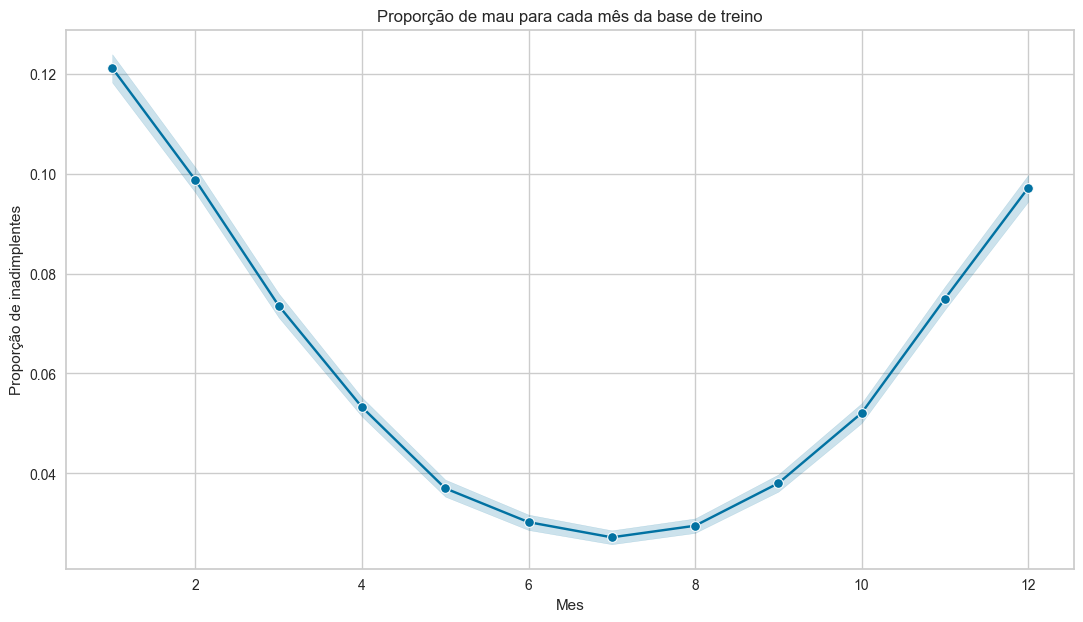

In [12]:
# Plotando um gráfico de linha usando 'Mes' no eixo x e 'mau' no eixo y
fig, ax = plt.subplots(figsize=(13,7))

sns.lineplot(data=df_train, x='Mes', y='mau', palette='mako', ax=ax, marker='o')
ax.set_title('Proporção de mau para cada mês da base de treino')
ax.set_ylabel("Proporção de inadimplentes");

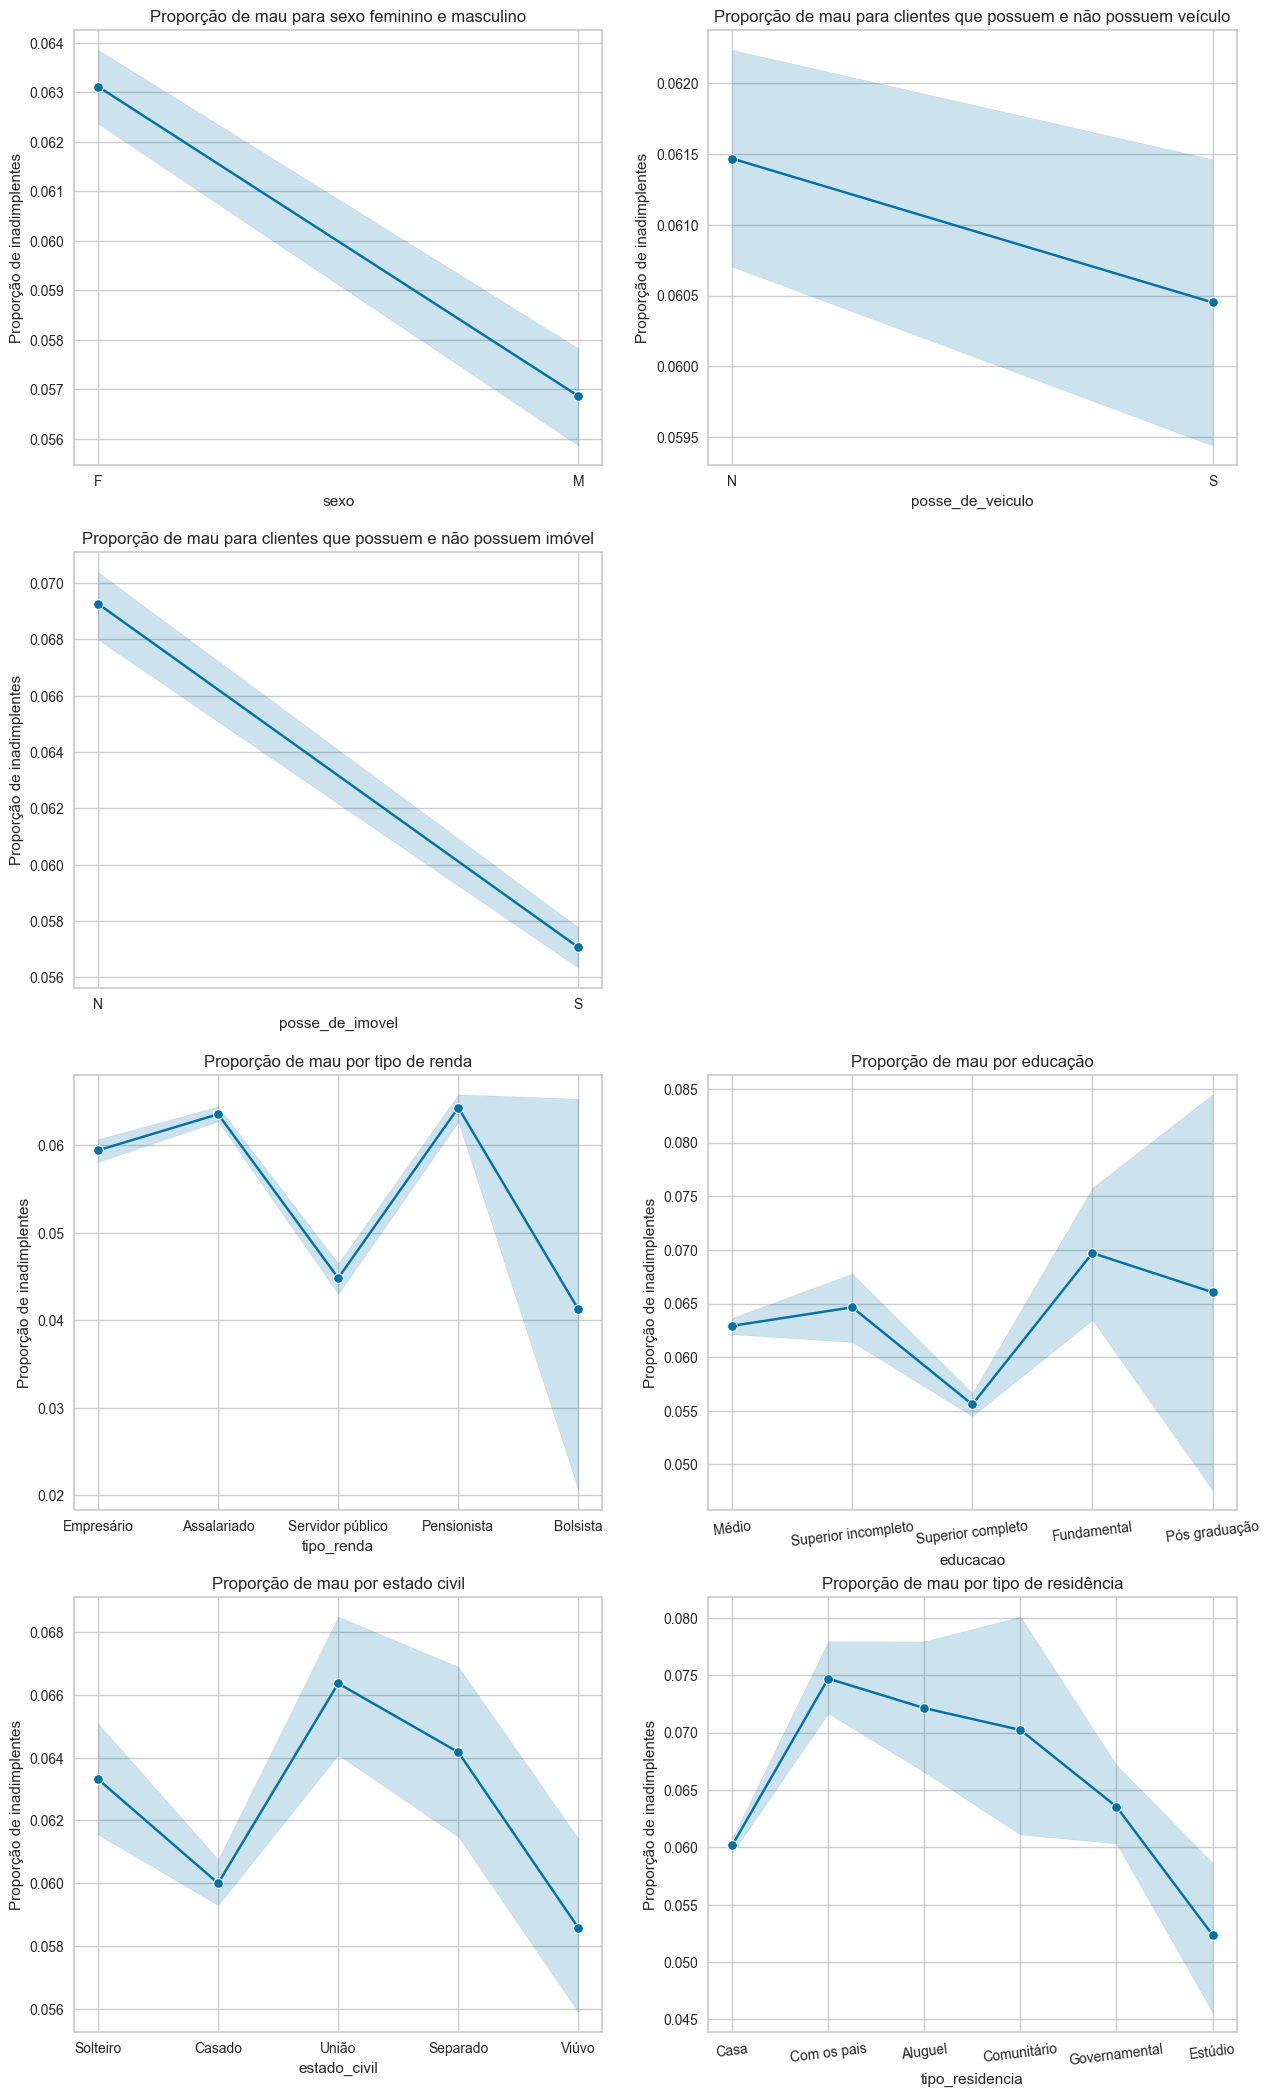

In [13]:
# Criando uma grade de subplots.
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação ao sexo.
sns.lineplot(data=df_train, x='sexo', y='mau', palette='mako', ax=ax[0, 0], marker='o')
ax[0, 0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0, 0].set_ylabel("Proporção de inadimplentes")

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação à posse de veículo.
sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', palette='mako', ax=ax[0, 1], marker='o')
ax[0, 1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0, 1].set_ylabel("Proporção de inadimplentes")

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação à posse de imóvel.
sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', palette='mako', ax=ax[1, 0], marker='o')
ax[1, 0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1, 0].set_ylabel("Proporção de inadimplentes")

# Desligando o subplot [1, 1].
ax[1, 1].axis('off')

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação ao tipo de renda.
sns.lineplot(data=df_train, x='tipo_renda', y='mau', palette='mako', ax=ax[2, 0], marker='o')
ax[2, 0].set_title('Proporção de mau por tipo de renda')
ax[2, 0].set_ylabel("Proporção de inadimplentes")

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação à educação.
sns.lineplot(data=df_train, x='educacao', y='mau', palette='mako', ax=ax[2, 1], marker='o')
ax[2, 1].set_title('Proporção de mau por educação')
ax[2, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(7)

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação ao estado civil.
sns.lineplot(data=df_train, x='estado_civil', y='mau', palette='mako', ax=ax[3, 0], marker='o')
ax[3, 0].set_title('Proporção de mau por estado civil')
ax[3, 0].set_ylabel("Proporção de inadimplentes")

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação ao tipo de residência.
sns.lineplot(data=df_train, x='tipo_residencia', y='mau', palette='mako', ax=ax[3, 1], marker='o')
ax[3, 1].set_title('Proporção de mau por tipo de residência')
ax[3, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(7)

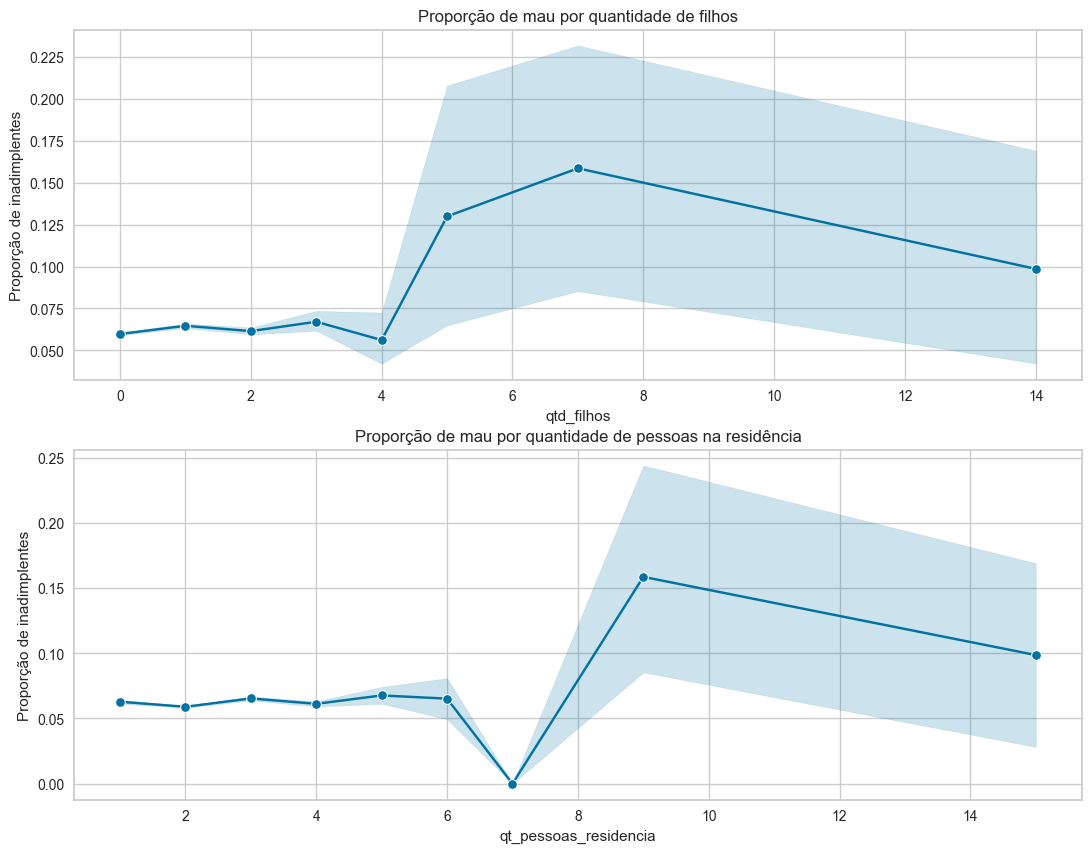

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação à quantidade de filhos ('qtd_filhos').
sns.lineplot(data=df_train, x='qtd_filhos', y='mau', palette='mako', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

# Plotando um gráfico de linha para a proporção de inadimplentes ('mau') em relação à quantidade de pessoas na residência ('qt_pessoas_residencia').
sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', palette='mako', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')
ax[1].set_ylabel("Proporção de inadimplentes");

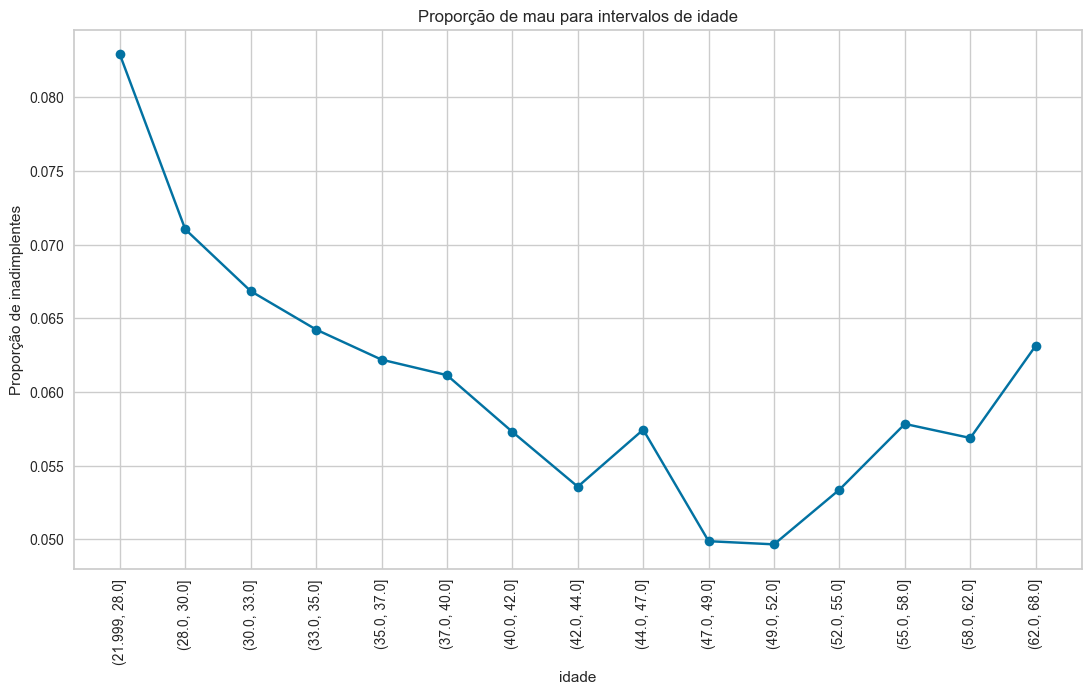

In [15]:
fig, ax = plt.subplots(figsize=(13, 7))

# Usando o método 'pd.qcut' para criar 15 intervalos de igual largura para a coluna 'idade'.
cat_1, bins = pd.qcut(df_train['idade'], 15, retbins=True)

# Agrupando o DataFrame com base nos intervalos criados e calculando a média da coluna 'mau' para cada grupo.
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

# Plotando um gráfico de linha.
ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")

# Definindo os rótulos do eixo x com os intervalos de idade.
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de idade');

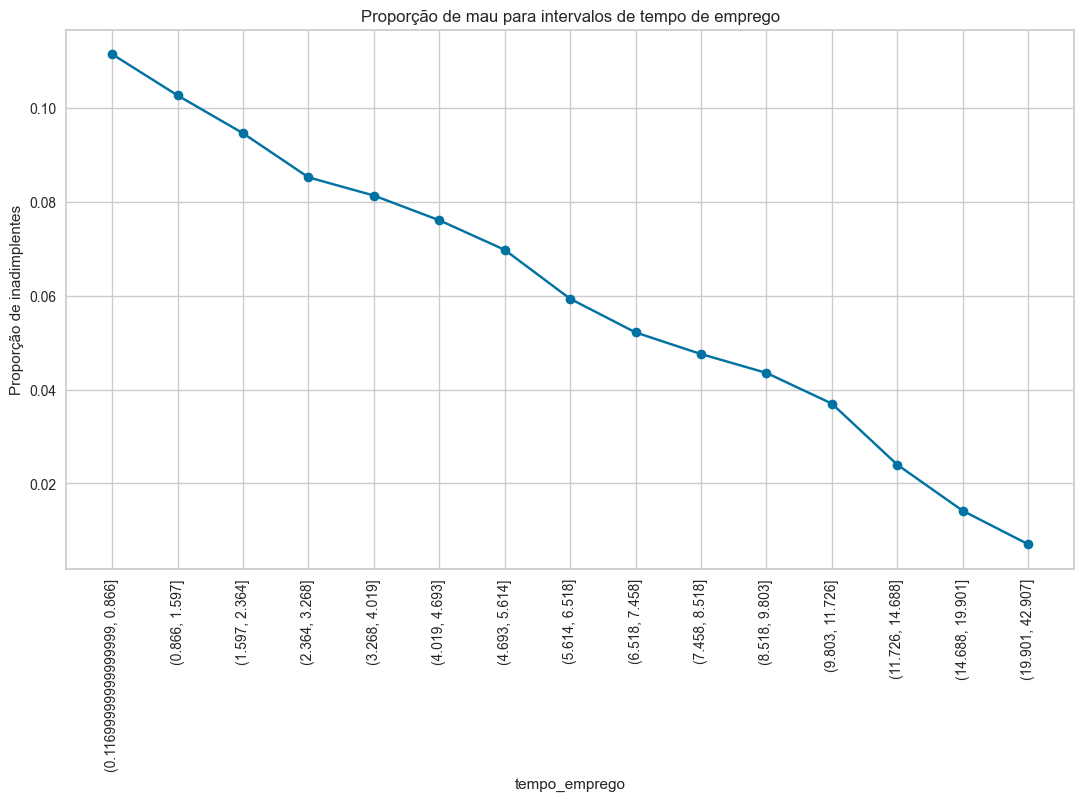

In [16]:
fig, ax = plt.subplots(figsize=(13, 7))

# Criando 15 intervalos de igual largura para a coluna 'tempo_emprego'.
# 'retbins=True' retorna os limites dos intervalos.
cat_1, bins = pd.qcut(df_train['tempo_emprego'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de tempo de emprego');

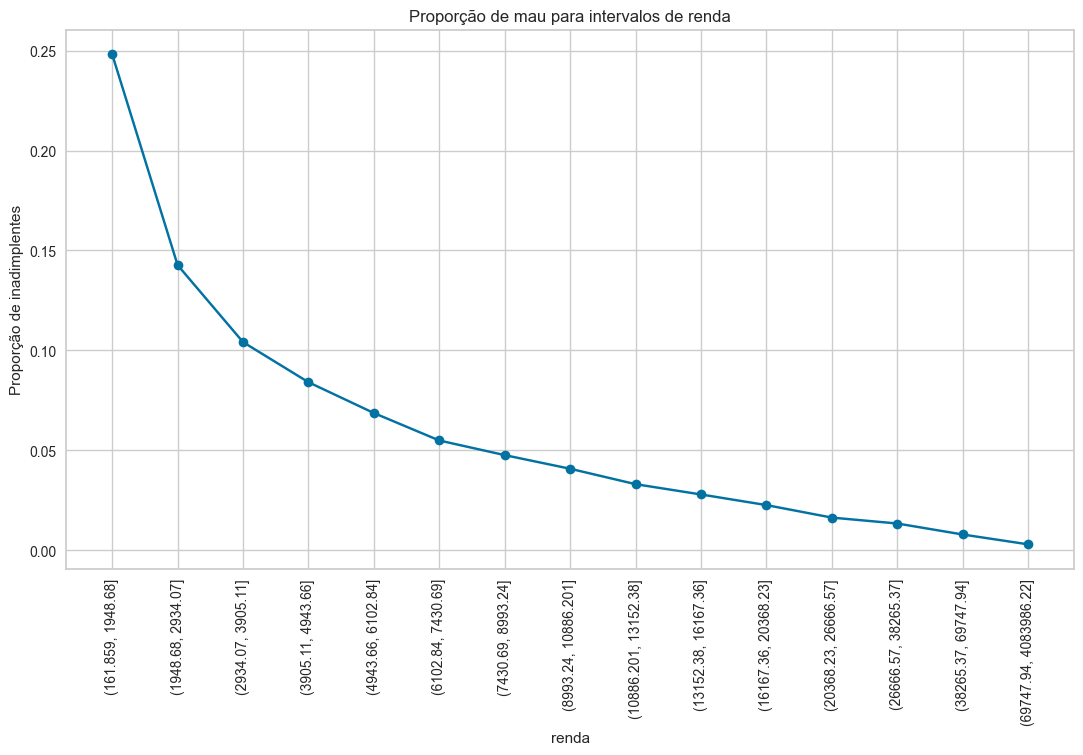

In [17]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de mau para intervalos de renda');

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [18]:
# Convertendo a coluna 'mau' para o tipo de dados 'int64'.
df_train['mau'] = df_train['mau'].astype('int64')

# Removendo as colunas 'data_ref', 'index' e 'Mes' do DataFrame 'df_train'.
df_train.drop(columns=['data_ref', 'index', 'Mes'], inplace=True)

In [19]:
# Substituindo valores ausentes pela média.
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)

# Criando um 'metadados'.
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['numeric'] = (metadados.dtype == 'int64') | (metadados.dtype == 'float64')
metadados['papel'] = 'covariavel'
metadados.loc['mau', 'papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,numeric,papel
sexo,object,0,2,False,covariavel
posse_de_veiculo,object,0,2,False,covariavel
posse_de_imovel,object,0,2,False,covariavel
qtd_filhos,int64,0,8,True,covariavel
tipo_renda,object,0,5,False,covariavel
educacao,object,0,5,False,covariavel
estado_civil,object,0,5,False,covariavel
tipo_residencia,object,0,6,False,covariavel
idade,int64,0,47,True,covariavel
tempo_emprego,float64,0,3005,True,covariavel


In [20]:
# Iterando por cada variável com papel 'covariavel' no DataFrame 'metadados'.
for var in metadados[metadados.papel == 'covariavel'].index:
    # Verificando se a variável possui mais de 10 valores únicos.
    if metadados.loc[var, 'valores_unicos'] > 10:
        # Calculando o IV usando 'pd.qcut' para discretizar a variável em 5 intervalos.
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var], 5, duplicates='drop'), df_train.mau)
    else:
        # Calculando o IV diretamente para a variável.
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
metadados

,dtype,nmissing,valores_unicos,numeric,papel,IV
sexo,object,0,2,False,covariavel,0.002665
posse_de_veiculo,object,0,2,False,covariavel,0.000075
posse_de_imovel,object,0,2,False,covariavel,0.009690
qtd_filhos,int64,0,8,True,covariavel,0.001689
tipo_renda,object,0,5,False,covariavel,0.009718
educacao,object,0,5,False,covariavel,0.003690
estado_civil,object,0,5,False,covariavel,0.001305
tipo_residencia,object,0,6,False,covariavel,0.003330
idade,int64,0,47,True,covariavel,0.018434
tempo_emprego,float64,0,3005,True,covariavel,0.283956


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


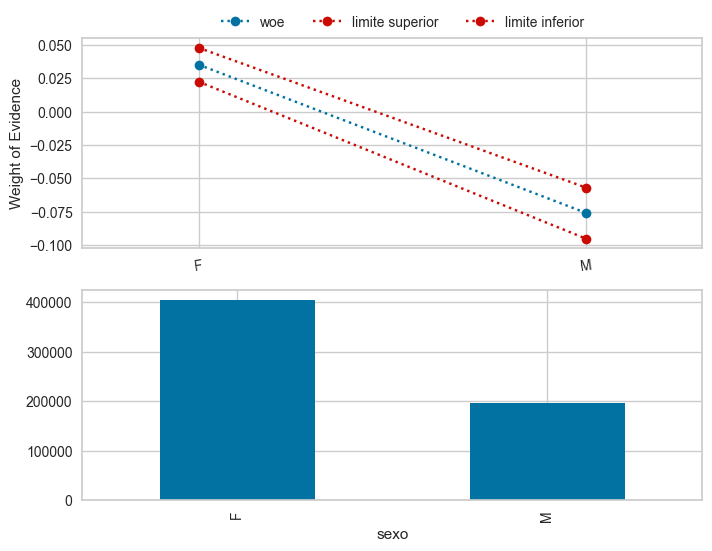

In [21]:
# Chamando a função 'biv_discreta' para calcular o IV da variável 'sexo' nos dados de treinamento.
biv_discreta('sexo', df_train)

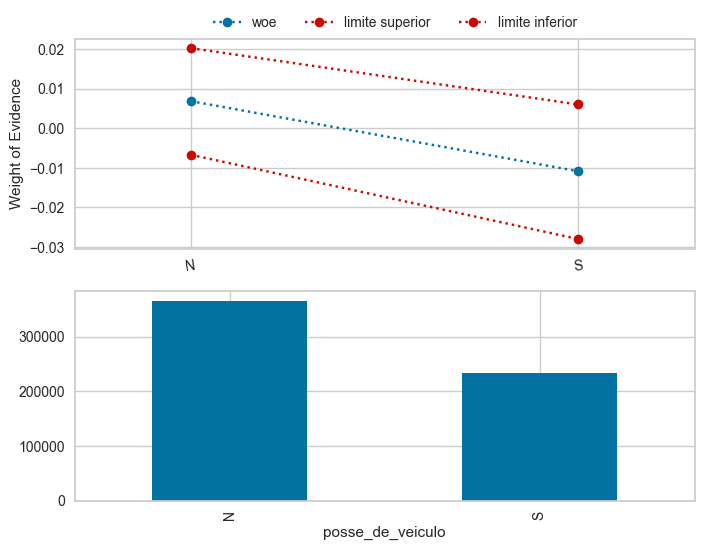

In [22]:
biv_discreta('posse_de_veiculo', df_train);

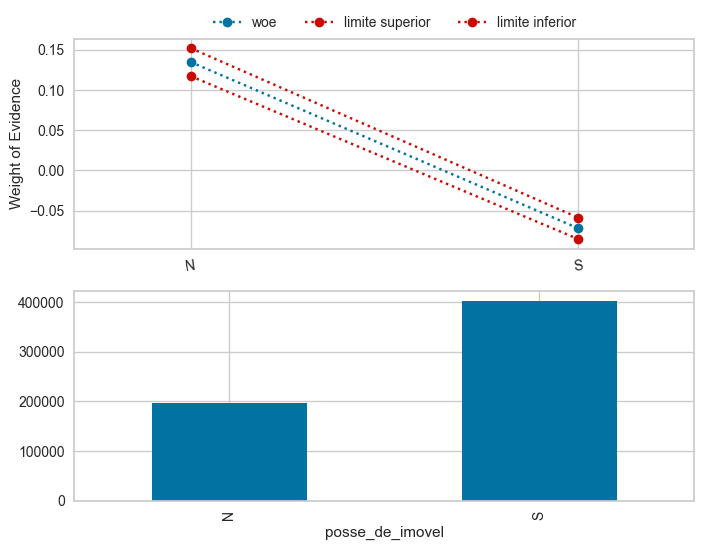

In [23]:
biv_discreta('posse_de_imovel', df_train);

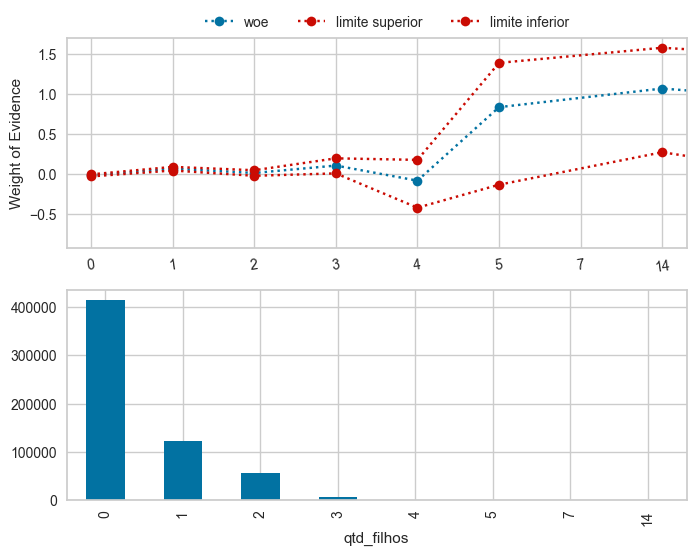

In [24]:
biv_discreta('qtd_filhos', df_train);

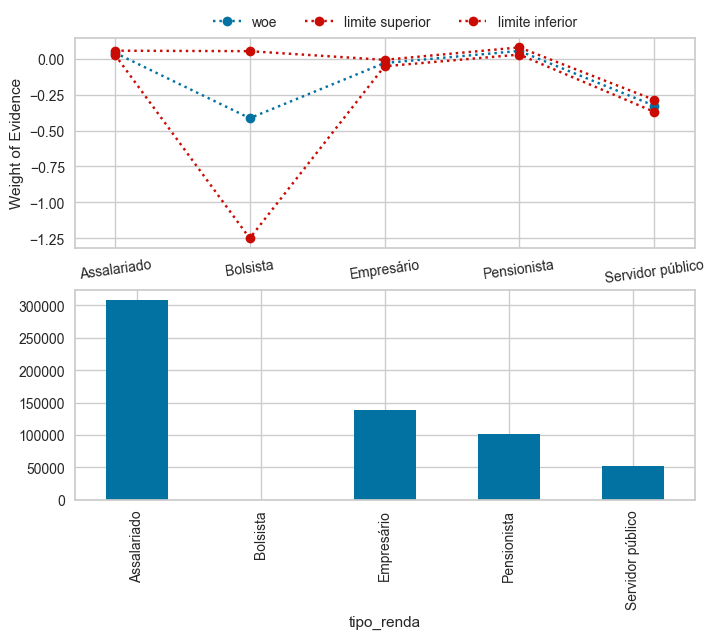

In [25]:
biv_discreta('tipo_renda', df_train);

0.009634301334170859

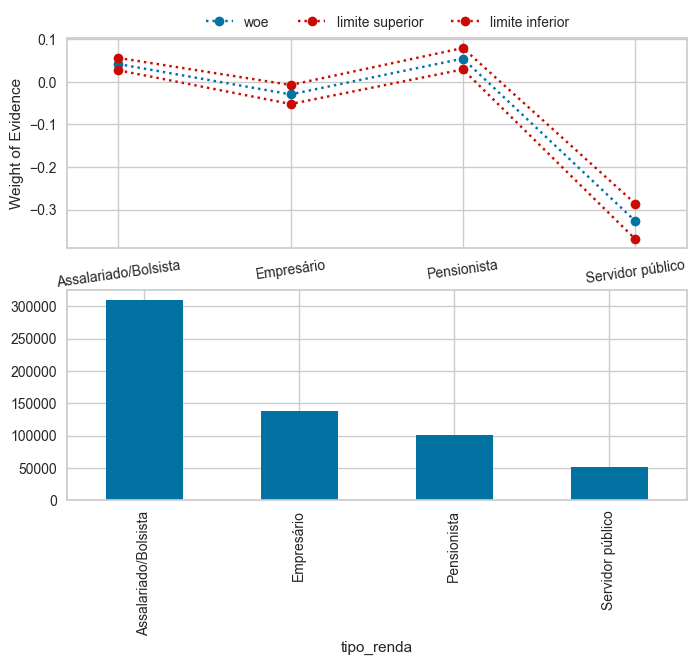

In [26]:
# Agrupando as classes da variável educacao

df_train.tipo_renda.replace({'Assalariado':'Assalariado/Bolsista', 
                      'Bolsista':'Assalariado/Bolsista',
                     }, inplace=True)

biv_discreta('tipo_renda', df_train);
IV(df_train.tipo_renda, df_train.mau)

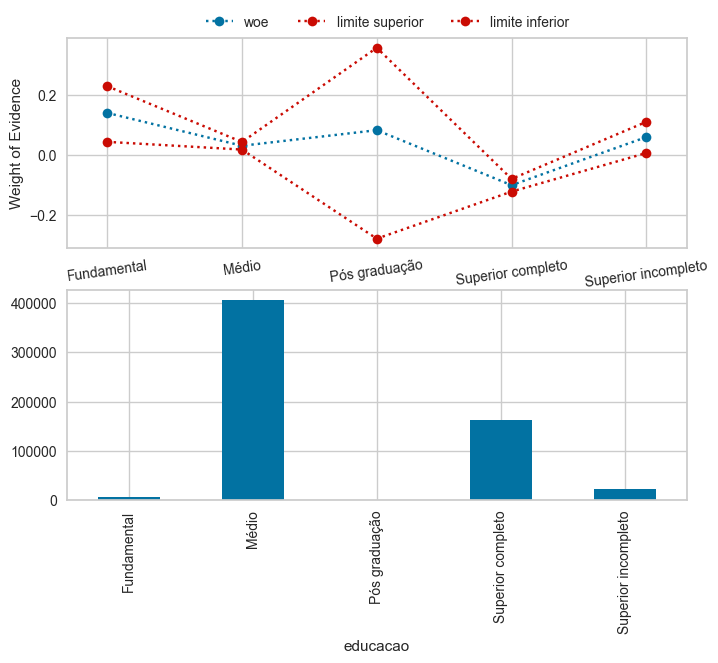

In [27]:
biv_discreta('educacao', df_train);

0.0034801108923340892

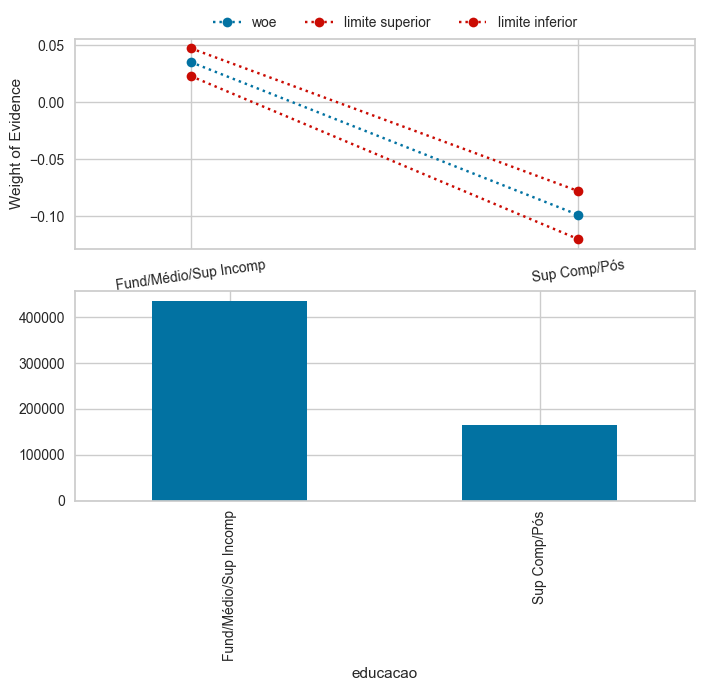

In [28]:
# Agrupando as classes da variável educacao

df_train.educacao.replace({'Fundamental':'Fund/Médio/Sup Incomp', 
                      'Médio':'Fund/Médio/Sup Incomp',
                      'Superior incompleto':'Fund/Médio/Sup Incomp',
                      'Superior completo': 'Sup Comp/Pós',
                      'Pós graduação': 'Sup Comp/Pós'
                     }, inplace=True)

biv_discreta('educacao', df_train);
IV(df_train.educacao, df_train.mau)

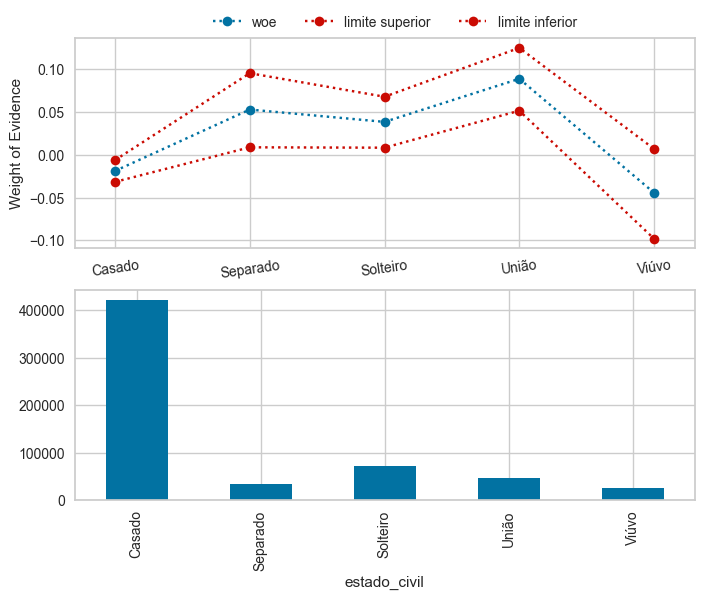

In [29]:
biv_discreta('estado_civil', df_train);

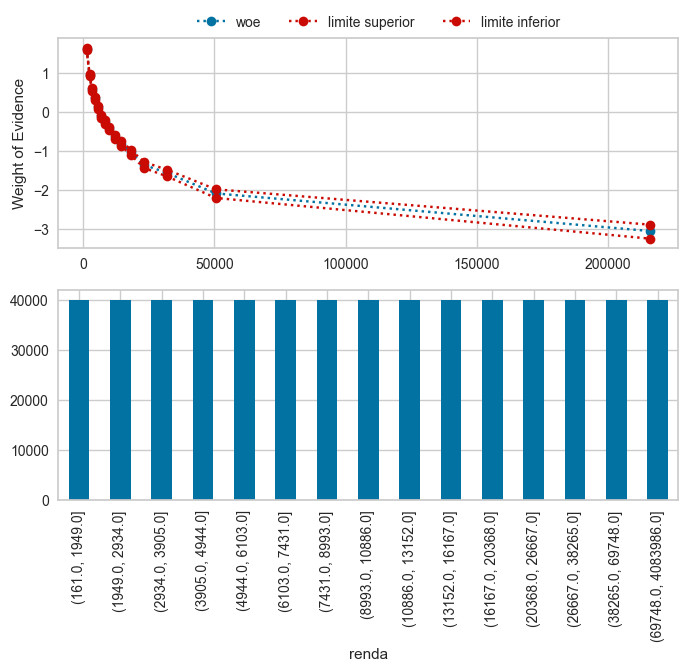

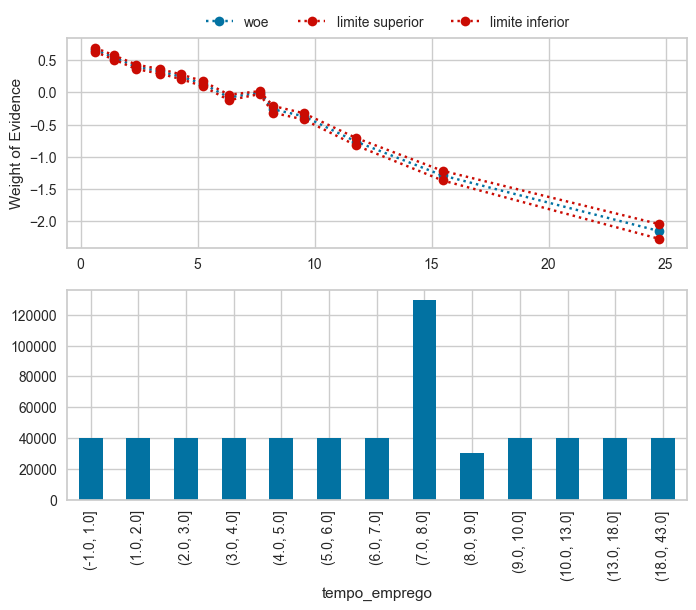

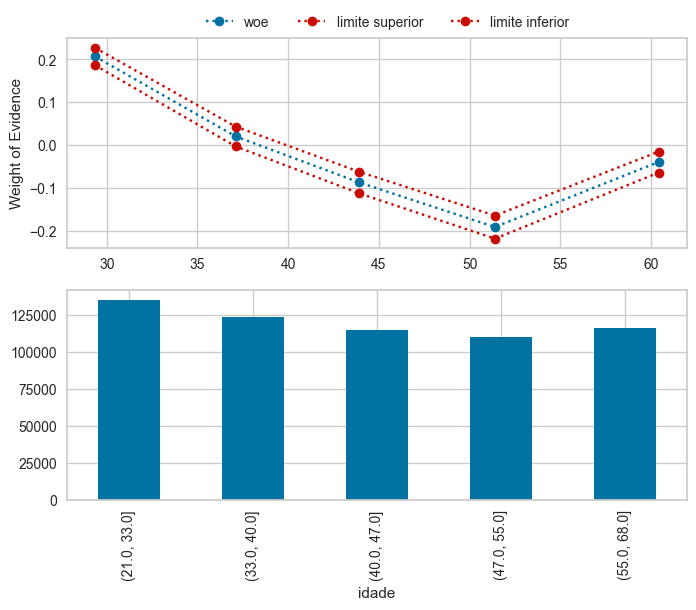

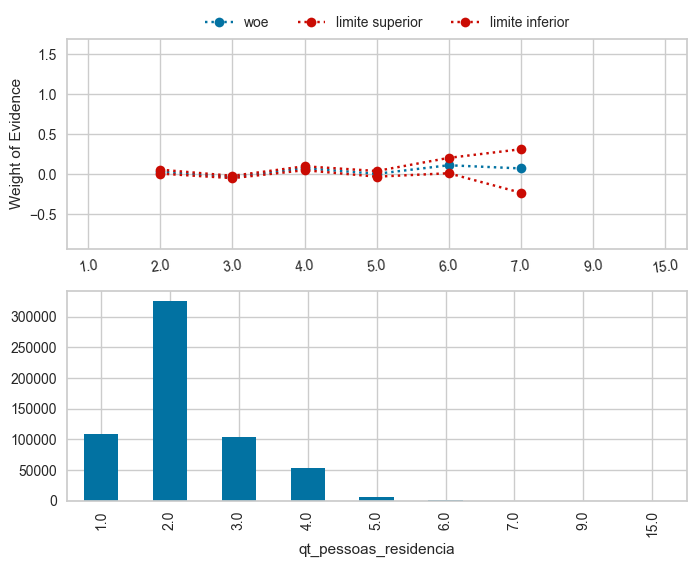

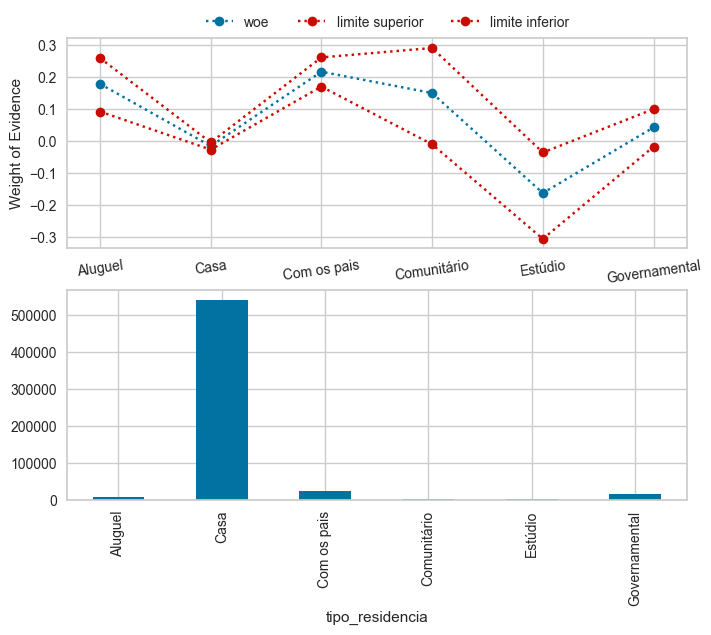

In [30]:
biv_continua('renda', 15, df_train)
biv_continua('tempo_emprego', 15, df_train)
biv_continua('idade', 5, df_train)
biv_discreta('qt_pessoas_residencia', df_train)
biv_discreta('tipo_residencia', df_train);

In [31]:
# Definindo a fórmula do modelo de regressão logística.
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

# Ajustando o modelo.
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Wed, 04 Oct 2023   Deviance:                   2.4965e+05
Time:                        16:18:05   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós]            -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [32]:
# Definindo a nova fórmula do modelo de regressão logística.
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Wed, 04 Oct 2023   Deviance:                   2.4969e+05
Time:                        16:18:14   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [33]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Wed, 04 Oct 2023   Deviance:                   2.4969e+05
Time:                        16:18:23   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [34]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + np.log(renda)
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Wed, 04 Oct 2023   Deviance:                   2.4055e+05
Time:                        16:18:31   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9194      0.051    115.829      0.000       5.819       6.020
sexo[T.M]                   -0.0018      0.012     -0.149      0.882      -0.026       0.022
posse_de_imovel[T.S]        -0.0175      0.012     -1.494      0.135      -0.040       0.005
educacao[T.Sup Comp/Pós]    -0.0056      0.013     -0.430      0.667      -0.031       0.020
tempo_emprego               -0.0010      0.002     -0.610      0.542      -0.004       0.002
np.log(renda)               -0.9881      0.007   -149.914      0.000      -1.001      -0.975
============================================================================================
"""

In [35]:
formula = '''
    mau ~ np.log(renda)
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2028e+05
Date:                Wed, 04 Oct 2023   Deviance:                   2.4055e+05
Time:                        16:18:32   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05719
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9239      0.049    121.382      0.000       5.828       6.020
np.log(renda)    -0.9908      0.006   -169.858      0.000      -1.002      -0.979
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [36]:
# Calculando as previsões do modelo de regressão logística e armazenando-as na coluna 'score' nos dados de treinamento.
df_train['score'] = rl.predict(df_train)

# Calculando a acurácia comparando as previsões com a variável de resposta 'mau'.
# Limiar de 0.068 para classificar como inadimplente.
acc = metrics.accuracy_score(df_train.mau, df_train.score > 0.068)

# Calculando a Curva ROC e a área sob a curva (AUC).
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)

# Calculando o índice de Gini usando a AUC.
gini = 2 * auc - 1

# Calculando a estatística KS usando a função ks_2samp para comparar as pontuações de inadimplentes e não inadimplentes.
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 71.9% 
AUC: 77.0% 
GINI: 54.0%
KS: 39.9%


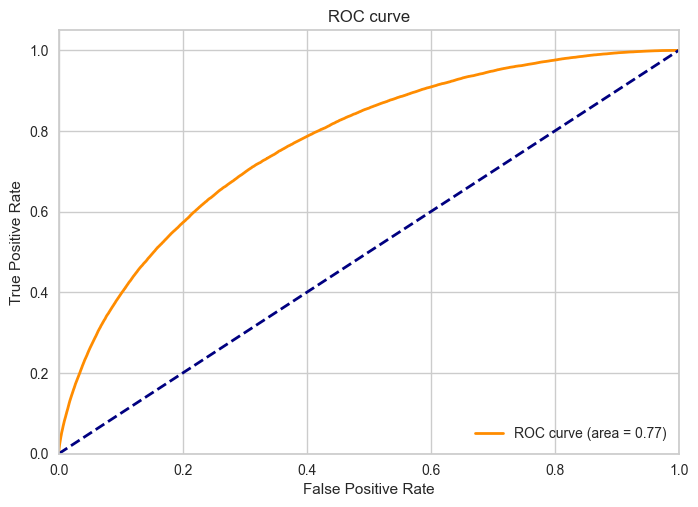

In [37]:
# Plotando a curva ROC.
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

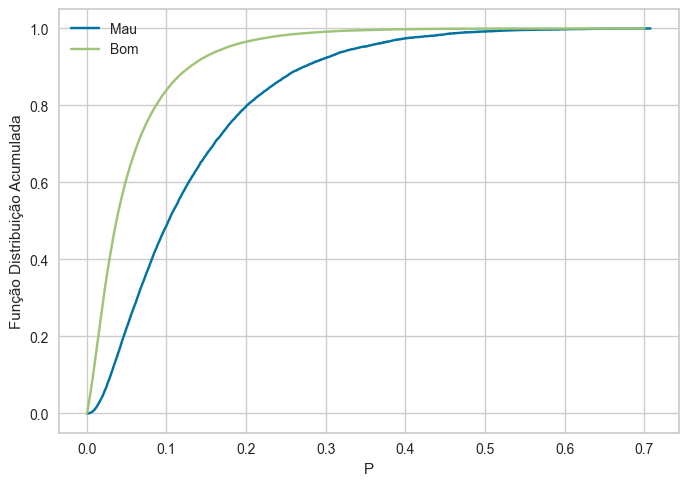

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Selecionando as pontuações (scores) para inadimplentes ('mau' igual a 1) e bons pagadores ('mau' diferente de 1).
score_pop1 = df_train.loc[df_train['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

# Ordenando as pontuações e calculando a função de distribuição acumulada para ambas as populações.
score_pop2 = df_train.loc[df_train['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada');

In [39]:
# Dados da base Out Of Time.
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)

df_test.educacao.replace({
    'Fundamental': 'Fund/Médio/Sup Incomp',
    'Médio': 'Fund/Médio/Sup Incomp',
    'Superior incompleto': 'Fund/Médio/Sup Incomp',
    'Superior completo': 'Sup Comp/Pós',
    'Pós graduação': 'Sup Comp/Pós'
}, inplace=True)

df_test['score'] = rl.predict(df_test)
acc = metrics.accuracy_score(df_test.mau, df_test.score > 0.068)
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)
gini = 2 * auc - 1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'], df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 39.3% 
AUC: 73.9% 
GINI: 47.8%
KS: 34.7%


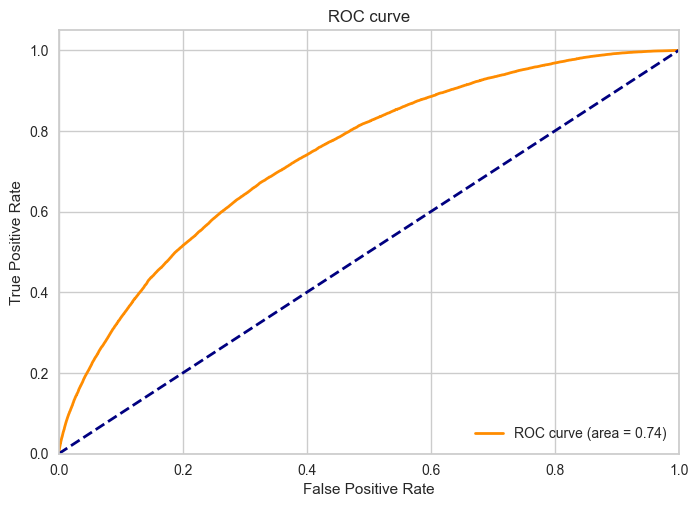

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

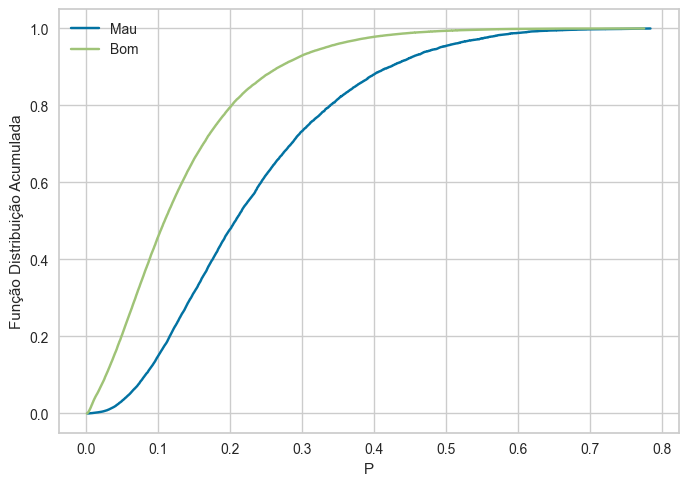

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_test.loc[df_test['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_test.loc[df_test['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada');

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [42]:
# Lendo os dados do arquivo feather 'credit_scoring.ftr' e armazenando-os no DataFrame 'df'.
df1 = pd.read_feather('credit_scoring.ftr')

# Convertendo a coluna 'mau' para o tipo de dados 'int64'.
df1['mau'] = df1['mau'].astype('int64')

# Removendo as colunas 'data_ref' e 'index' do DataFrame 'df'.
df1.drop(columns=['data_ref', 'index'], axis=1, inplace=True)
df1.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')

In [43]:
# Amostrando aleatoriamente 50.000 registros
df2 = df1.sample(n=50000, random_state=999)

# Amostrando aleatoriamente 95% dos registros
df = df2.sample(frac=0.95, random_state=786)

# Criando um conjunto de dados com os registros não utilizados no treinamento/teste.
data_unseen = df2.drop(df.index)

# Reindexando os conjuntos de dados para ter índices sequenciais.
df.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

# Exibindo o tamanho dos conjuntos de dados.
print('Conjunto de dados para modelagem (treino e teste): ' + str(df.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


## Pré processamento

In [44]:
# Selecionando as colunas numéricas e excluindo a coluna 'mau'.
numerics = df1.select_dtypes(include='number').columns.drop('mau').tolist()

# Selecionando as colunas categóricas.
categorical = df1.select_dtypes(exclude='number').columns.tolist()

print(numerics)
print(categorical)

['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']


### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

<span style= "color: darkolivegreen;"> Esse passo e os seguintes serão feitos no pycaret</span>  

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [45]:
# Criando um transformador de pipeline chamado 'categorical_transformer'.
# Aplicando a codificação one-hot para variáveis categóricas.
# 'handle_unknown' é definido como 'ignore' para lidar com categorias desconhecidas.
# 'sparse' é definido como 'False' para obter uma matriz densa em vez de esparsa.
categorical_transformed = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))
categorical_transformed

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [46]:
# Aplicando o 'categorical_transformer' às colunas categóricas.
column_transformer = ColumnTransformer(
    transformers=[("cat", categorical_transformed, categorical),])

# Criando um pipeline de pré-processamento chamado 'preprocess'.
# Este pipeline inclui o transformador 'column_transformer' que você definiu anteriormente.
preprocess = make_pipeline(column_transformer)
preprocess

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])]))])

In [47]:
%%time
# Configurando a preparação dos dados usando a função setup do PyCaret.
exp_clf = setup(data=df, 
                target = 'mau', 
                session_id=123, 
                numeric_features = numerics,
                categorical_features = categorical,
                numeric_imputation = True,
                categorical_imputation = 'mode',
                polynomial_features = True,
                normalize = True,
                fix_imbalance = True,
                remove_outliers = True,
                outliers_threshold = 0.02,
                feature_selection = True,
                n_features_to_select = 5,
                pca = True, 
                pca_components = 5) 

[LightGBM] [Info] Number of positive: 30050, number of negative: 30050
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 60100, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(74350, 6)"
5,Transformed train set shape,"(60100, 6)"
6,Transformed test set shape,"(14250, 6)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


CPU times: user 23.8 s, sys: 2.53 s, total: 26.4 s
Wall time: 15.6 s


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [49]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [50]:
# Criando um modelo LightGBM para classificação usando a função create_model do PyCaret.
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8123,0.6599,0.2646,0.1352,0.1789,0.0854,0.0915
1,0.8033,0.6481,0.2879,0.1358,0.1845,0.0888,0.0970
2,0.8141,0.6495,0.2840,0.1440,0.1911,0.0986,0.1059
3,0.8018,0.6620,0.3152,0.1436,0.1973,0.1020,0.1122
4,0.8120,0.6578,0.2257,0.1198,0.1565,0.0618,0.0658
5,0.8117,0.6448,0.3074,0.1499,0.2015,0.1089,0.1180
6,0.7997,0.5839,0.2023,0.1014,0.1351,0.0358,0.0385
7,0.8039,0.6133,0.2519,0.1240,0.1662,0.0695,0.0751
8,0.8033,0.6413,0.2713,0.1306,0.1763,0.0799,0.0869


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

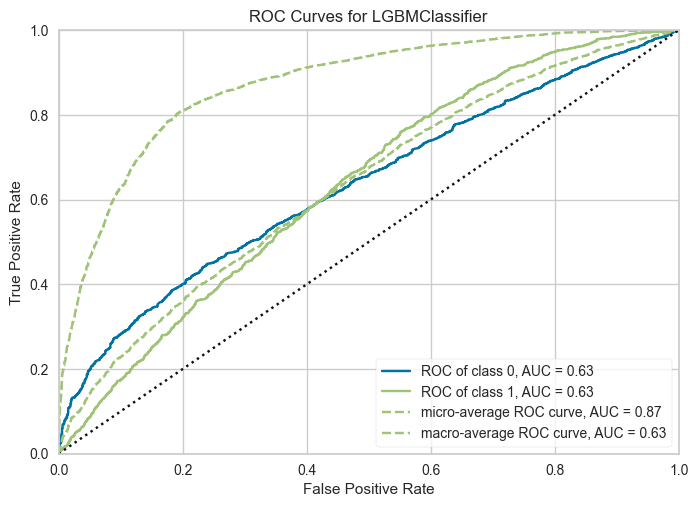

In [51]:
# Criando um gráfico da curva ROC e exibindo a AUC.
plot_model(lgbm_model, plot='auc')

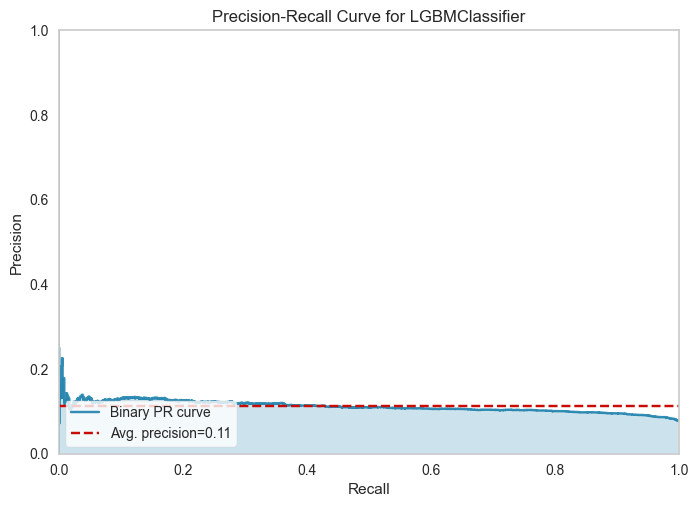

In [52]:
# Criando um gráfico da curva Precision-Recall.
plot_model(lgbm_model, plot='pr')

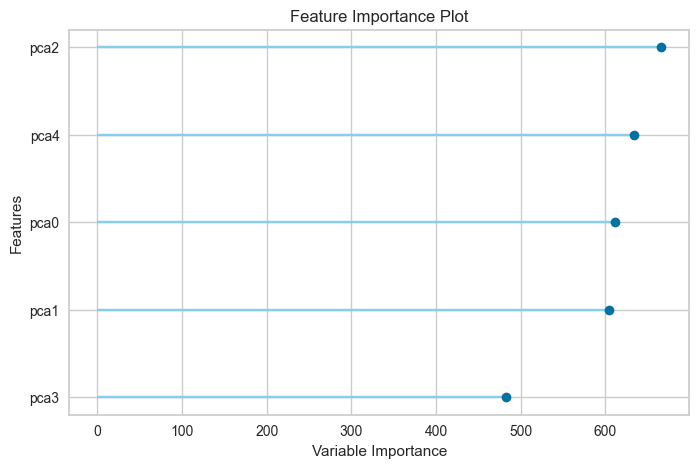

In [53]:
# Criando um gráfico de importância das características.
plot_model(lgbm_model, plot='feature')

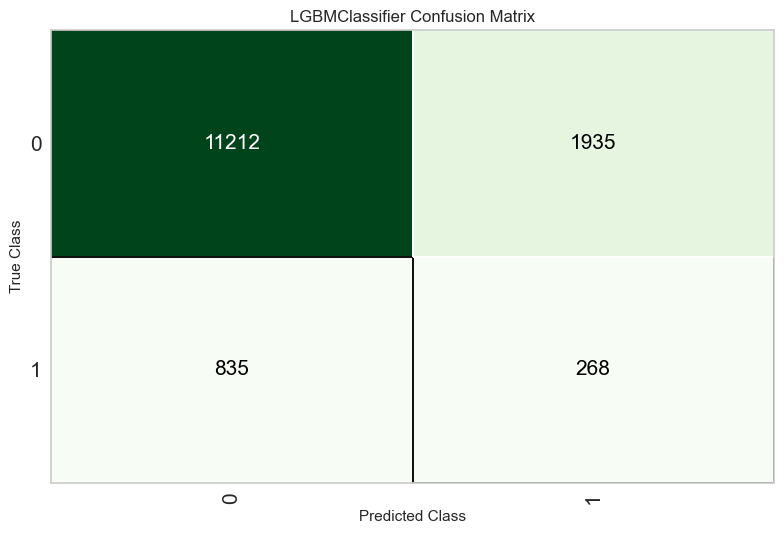

In [54]:
# Criando uma matriz de confusão.
plot_model(lgbm_model, plot='confusion_matrix')

In [55]:
# Fazendo previsões usando o modelo LightGBM.
predictions = predict_model(lgbm_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8056,0.6340,0.2430,0.1217,0.1621,0.0658,0.0708


In [58]:
# Obtendo os parâmetros finais do modelo LightGBM após o treinamento.
final_lgbm = finalize_model(lgbm_model)
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=True,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='constant',
                                                              verbose='deprecated'))),
                ('categorica...
                 LGBMClassifier(boosting_type='gbdt', c

In [59]:
# Fazendo previsões usando o modelo LightGBM finalizado.
predictions = predict_model(final_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.4330,0.5913,0.7226,0.0930,0.1648,0.0320,0.0716


In [60]:
# Fazendo previsões usando o modelo LightGBM finalizado no conjunto de dados não visto.
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8096,0.6458,0.2897,0.1606,0.2067,0.1085,0.1146


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,M,S,S,1,Assalariado,Médio,Casado,Casa,29,3.934247,3.0,24058.269531,0,0,0.6359
1,M,N,N,1,Assalariado,Médio,Casado,Com os pais,25,5.298630,3.0,4157.000000,0,0,0.7962
2,M,S,S,1,Assalariado,Médio,Casado,Casa,38,6.068493,3.0,6271.189941,0,0,0.6484
3,F,N,N,1,Empresário,Superior incompleto,Casado,Com os pais,32,7.561644,3.0,8513.190430,0,0,0.6652
4,F,N,S,0,Pensionista,Médio,União,Casa,55,NaN,2.0,5703.330078,0,0,0.7543


In [61]:
# Salvando o modelo LightGBM finalizado.
save_model(final_lgbm, 'Final LGBM Model 22Nov2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=True,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='constant',
                                                               verbose='deprecated'))),
                 ('categorica...
                  LGBMClassifier(boosting

In [62]:
# Carregando o modelo LightGBM finalizado.
saved_final_lgbm = load_model('Final LGBM Model 22Nov2022')

Transformation Pipeline and Model Successfully Loaded


In [63]:
# Acessando os passos do modelo LightGBM finalizado.
saved_final_lgbm.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=True,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='constant',
                                              verbose='deprecated')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
 